# Synthetic Distribution Shift

---
## Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

from utils import Logger, Plotter

---
## Setting & Parameters

In [2]:
num_classes   = 10
batch_size    = 128 
num_epochs    = 30
learning_rate = 0.007    

# seed for random numbers
torch.manual_seed(13)

# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device', device)

device cuda


---
## Helpers

In [3]:
# resize and normalize the data to [-1, +1]
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)) 
])

transform_noise = transforms.Compose([
    transforms.Lambda(lambda t : 2*(t - t.min())/(t.max()-t.min()) - 1)
])

# wrapper function to disply images
def display_images(X, n_cols=5):
    reverse_transform = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t : 255. * torch.clamp(t, 0, 1)),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t.detach().cpu().numpy().astype(np.uint8)),
        transforms.ToPILImage()
    ])
    Plotter.plot_imgs(-X, ncols=n_cols, transform=reverse_transform, figscale=1.5)

# check data
def check_data(data):
    loader = DataLoader(data, batch_size=50, shuffle=True)
    for X, _ in loader:  
        print('Image batch dimensions:', X.shape)
        print('Max pixel value:', X.max().numpy())
        print('Min pixel value:', X.min().numpy())
        break
    display_images(X[:5])

def corrupt(x, alpha):
    noise = torch.rand_like(x)
    return transform_noise((1-alpha)*x + alpha*noise)


---
## MNIST Data

Image batch dimensions: torch.Size([50, 1, 32, 32])
Max pixel value: 1.0
Min pixel value: -1.0


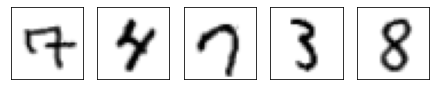

Image batch dimensions: torch.Size([50, 1, 32, 32])
Max pixel value: 1.0
Min pixel value: -1.0


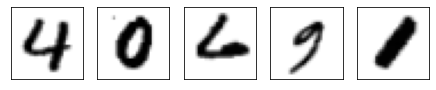

In [4]:
# training examples
mnist_train = datasets.MNIST(
    root='data', 
    train=True,
    download=True, 
    transform=transform
)

# test examples
mnist_test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

# train and test loader
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

# check data
check_data(mnist_train)
check_data(mnist_test)

---
## Noisy Images

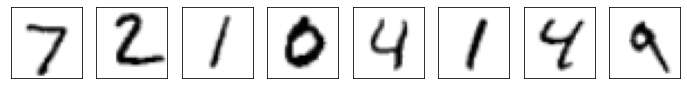

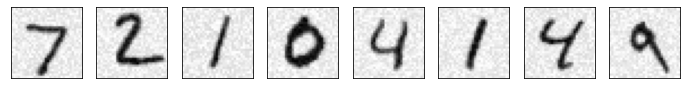

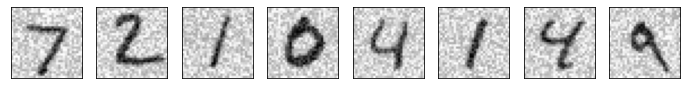

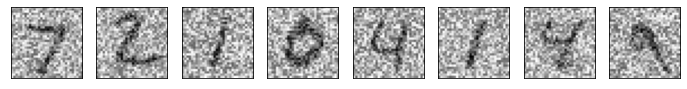

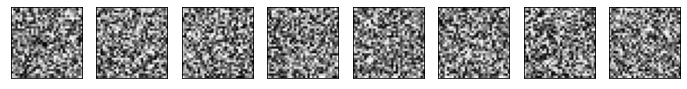

In [5]:
X, _ = next(iter(test_loader))
n_demo = 8
X_demo = X[:n_demo]
alphas = torch.linspace(0, 1, 5) 
for alpha in alphas:
    x = corrupt(X_demo, alpha)
    display_images(x, n_cols=n_demo)

---
## LeNet 5

In [6]:
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(400, 120), 
            nn.Tanh(),
            nn.Linear(120, 84), 
            nn.Tanh(),
            nn.Linear(84, num_classes))
        
    def forward(self, x):
        return self.net(x)


---
## Linear Model

In [7]:
class Linear(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32, num_classes))
        
    def forward(self, x):
        return self.net(x)

---
## Training and Evaluation

In [8]:
def fit(model, train_loader):
    ### Compile model ############################################################# 
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    logger = Logger(2, '{:03d} | loss: {:8.4f} | acc: {:.3f}')
    
    ### Train #####################################################################
    for epoch in range(1, num_epochs + 1):
        
        model.train()
        for batch_idx, (X, y) in enumerate(train_loader):
            
            X = X.to(device)
            y = y.to(device)
    
            z = model(X)
            loss = F.cross_entropy(z, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        ### logging
        model.eval()
        loss, acc = eval(model, train_loader)
        logger.log_epoch([loss, acc])
        if not epoch % 1:
            logger.info()
    
    return model


# return classification accuracy and loss
def eval(model, data_loader, alpha=None):
    n_correct, n_total, loss = 0, 0, 0
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            if alpha:
                X = corrupt(X, alpha)
            y = y.to(device)
            z = model(X)
            loss += F.cross_entropy(z, y).item()
            _, y_hat = torch.max(z, 1)
            n_correct += (y_hat == y).sum().item()
            n_total += y.size(0)
    return loss, n_correct / n_total 

---
## Experiment: LeNet5

#### Fit Model

In [9]:
model = LeNet5(num_classes)
model = fit(model, train_loader)

_, acc = eval(model, train_loader)
print(f'train accuracy: {acc:.3f}%')

001 | loss: 715.1687 | acc: 0.684
002 | loss: 254.3344 | acc: 0.875
003 | loss: 157.7862 | acc: 0.917
004 | loss: 120.3454 | acc: 0.933
005 | loss:  98.8670 | acc: 0.943
006 | loss:  83.7222 | acc: 0.951
007 | loss:  73.5199 | acc: 0.957
008 | loss:  66.0172 | acc: 0.961
009 | loss:  59.5473 | acc: 0.965
010 | loss:  53.8669 | acc: 0.969
011 | loss:  50.7888 | acc: 0.970
012 | loss:  46.5321 | acc: 0.973
013 | loss:  43.4464 | acc: 0.975
014 | loss:  40.7420 | acc: 0.977
015 | loss:  38.2598 | acc: 0.978
016 | loss:  36.7837 | acc: 0.979
017 | loss:  33.8798 | acc: 0.981
018 | loss:  32.4017 | acc: 0.981
019 | loss:  31.0347 | acc: 0.982
020 | loss:  32.6064 | acc: 0.980
021 | loss:  29.0897 | acc: 0.983
022 | loss:  27.3789 | acc: 0.984
023 | loss:  26.0383 | acc: 0.985
024 | loss:  25.0201 | acc: 0.986
025 | loss:  24.4710 | acc: 0.986
026 | loss:  23.9147 | acc: 0.986
027 | loss:  24.3146 | acc: 0.986
028 | loss:  22.9100 | acc: 0.987
029 | loss:  21.2941 | acc: 0.988
030 | loss:  2

#### Test Model

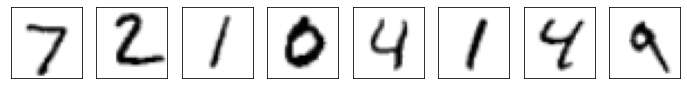

test accuracy : 0.985%



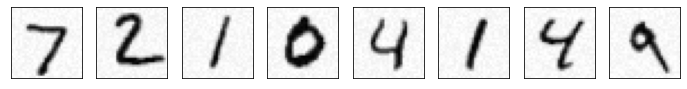

test accuracy : 0.984%



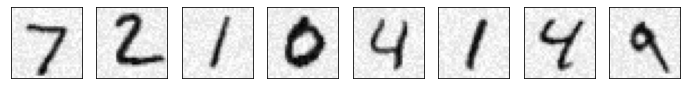

test accuracy : 0.984%



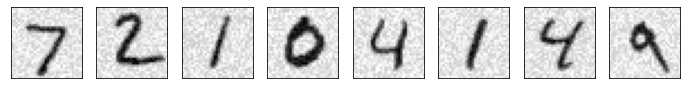

test accuracy : 0.983%



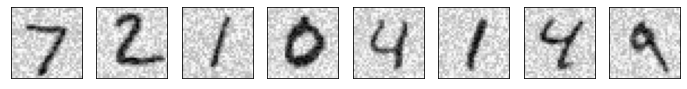

test accuracy : 0.981%



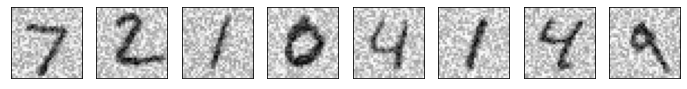

test accuracy : 0.973%



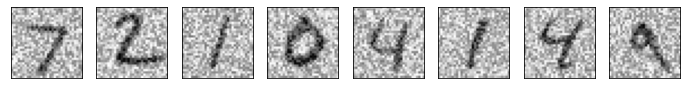

test accuracy : 0.915%



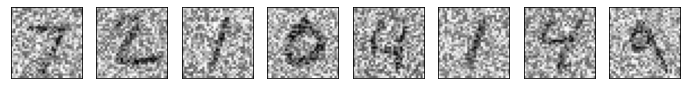

test accuracy : 0.690%



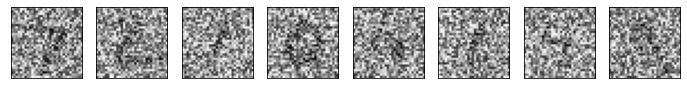

test accuracy : 0.324%



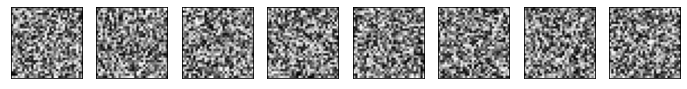

test accuracy : 0.101%



In [10]:
test_acc_lenet = []

alphas = torch.linspace(0, 1, 10) 
for alpha in alphas:
    _, acc = eval(model, test_loader, alpha)
    test_acc_lenet.append(acc)
    X_noisy = corrupt(X_demo, alpha)
    display_images(X_noisy, n_cols=len(X_demo))
    print(f'test accuracy : {acc:.3f}%')
    print()

---
## Experiment: Linear Model


#### Fit Model

In [11]:
model = Linear(num_classes)
model = fit(model, train_loader)

_, acc = eval(model, train_loader)
print(f'train accuracy: {acc:.3f}%')

001 | loss: 242.4326 | acc: 0.870
002 | loss: 202.8843 | acc: 0.884
003 | loss: 184.6285 | acc: 0.892
004 | loss: 175.3042 | acc: 0.895
005 | loss: 169.0821 | acc: 0.898
006 | loss: 164.4495 | acc: 0.901
007 | loss: 160.7313 | acc: 0.902
008 | loss: 156.9484 | acc: 0.906
009 | loss: 154.4476 | acc: 0.907
010 | loss: 152.3184 | acc: 0.908
011 | loss: 150.5159 | acc: 0.910
012 | loss: 148.8500 | acc: 0.910
013 | loss: 148.2694 | acc: 0.909
014 | loss: 146.4140 | acc: 0.911
015 | loss: 145.2901 | acc: 0.912
016 | loss: 144.6773 | acc: 0.913
017 | loss: 143.5931 | acc: 0.913
018 | loss: 142.7924 | acc: 0.913
019 | loss: 141.7555 | acc: 0.914
020 | loss: 141.0227 | acc: 0.915
021 | loss: 140.8779 | acc: 0.915
022 | loss: 139.9047 | acc: 0.916
023 | loss: 139.5671 | acc: 0.916
024 | loss: 138.6585 | acc: 0.915
025 | loss: 138.1617 | acc: 0.916
026 | loss: 138.1911 | acc: 0.916
027 | loss: 137.4244 | acc: 0.917
028 | loss: 136.9178 | acc: 0.917
029 | loss: 136.6127 | acc: 0.917
030 | loss: 13

#### Test Model

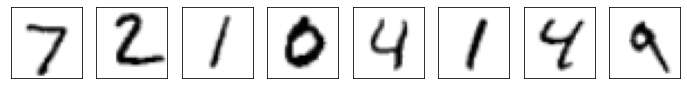

test accuracy : 0.922%



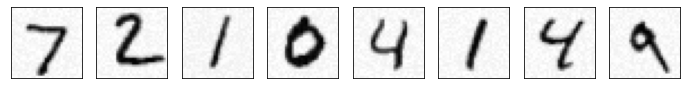

test accuracy : 0.920%



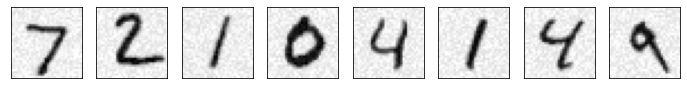

test accuracy : 0.920%



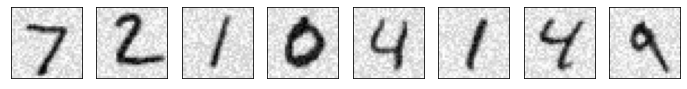

test accuracy : 0.919%



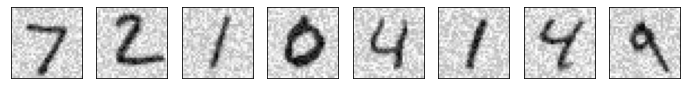

test accuracy : 0.917%



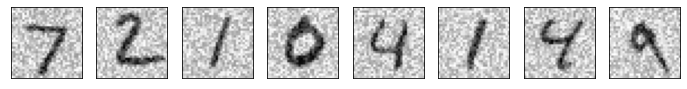

test accuracy : 0.908%



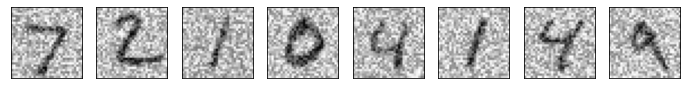

test accuracy : 0.895%



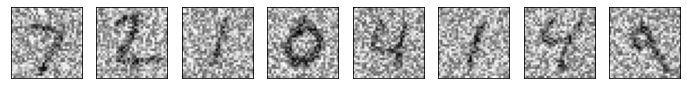

test accuracy : 0.836%



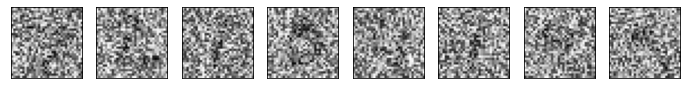

test accuracy : 0.590%



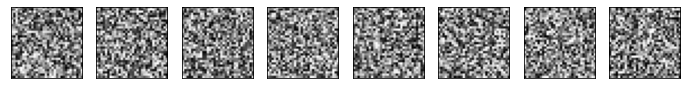

test accuracy : 0.105%



In [12]:
test_acc_linear = []

alphas = torch.linspace(0, 1, 10) 
for alpha in alphas:
    _, acc = eval(model, test_loader, alpha)
    test_acc_linear.append(acc)
    X_noisy = corrupt(X_demo, alpha)
    display_images(X_noisy, n_cols=len(X_demo))
    print(f'test accuracy : {acc:.3f}%')
    print()

---
## Compare Results

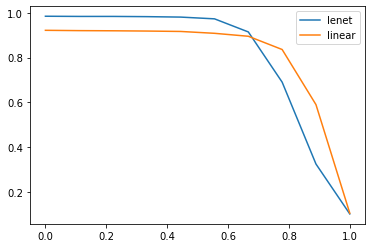

In [13]:
plt.plot(alphas, test_acc_lenet, label='lenet')
plt.plot(alphas, test_acc_linear, label='linear')
plt.legend()
plt.show()